---
<h1><center>Lesson 3.2 - Geovisualization with Python</center></h1>

---

This lesson is devoted to usually met question about the representation of data on maps - geovisualization. As was mentioned in the previous lesson **Lesson 3.1** Python is supplemented with a set of libraries fo visualisation using maps. Here we consider only two of them: matplotlib including specific extraction _basemap_ and _folium_. 

## Datasets reading and processing data

We’ll be using airports, airlines, and flights data from [Kaggle](https://www.kaggle.com/usdot/flight-delays/data). Airports includes IATA airport codes and names. Airlines includes IATA airline codes and names. Flights includes commercial airline flights in 2015. The original data from Kaggle includes information for the whole year. In this lesson, we use only flights data only for 1st decade of Jan 2015.

In [2]:
import os
import pandas as pd

# Change display oprions to see all 32 columns from flights dataset
pd.options.display.max_columns = 32

# Define folder with CSV files
data_dir = "data"

# Create a DataFrame for airports data 
airports = pd.read_csv(os.path.join(data_dir, 'Airports.csv'))
print ("Dataset contains {} rows.".format(len(airports.index)))
airports.head()

Dataset contains 322 rows.


,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [4]:
# Create a DataFrame for airlines data
airlines = pd.read_csv(os.path.join(data_dir, 'Airlines.csv'))
print ("Dataset contains {} rows.".format(len(airlines.index)))
airlines.head()

Dataset contains 14 rows.


,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [5]:
# And a separate DataFrame for flights
flights = pd.read_csv(os.path.join(data_dir, 'flights_first_decade_Jan_2015.csv'))
print ("Dataset contains {} rows.".format(len(flights.index)))
flights.head()

Dataset contains 154272 rows.


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


The chosen data is inherently a good fit for mapping – we have latitude and longitude pairs for airports, and for source and destination airports.

The first map we can make is one that shows all the airports in USA. We can do this with the basemap extension to matplotlib. This enables drawing USA map and adding points, and is very customizable.

In [6]:
mean_departure_delay = flights.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY'].mean().to_frame()
mean_departure_delay.reset_index(level=0, inplace=True)

airports = airports.merge(mean_departure_delay, left_on='IATA_CODE', right_on='ORIGIN_AIRPORT', how='left')
del airports['ORIGIN_AIRPORT']
print ("Dataset has shape {}.".format(airports.shape))
airports.head()

Dataset has shape (322, 8).


,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,DEPARTURE_DELAY
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040,9.416667
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190,15.476190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919,18.350459
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183,63.526316
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447,0.708333


In [13]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

# This defines the size of the image below
plt.rcParams['figure.figsize'] = (18, 12)

# Create a map on which to draw. We're using a `Lambert Conformal Projection` projection, and showing the whole USA.
# resolution: the resolution of he included coastlines, lakes, and so on. The crude resolution is chosen.
# area_thresh: the threshold under what no coast line or lake will be drawn.
# lat_0, lon_0: latitude and longitude of map center.
themap = Basemap(width=12000000,
                 height=9000000,
                 projection='lcc', # more info here https://matplotlib.org/basemap/users/lcc.html
                 resolution='c',
                 lat_1=45, # first standard parallel
                 lat_2=55, # second standard parallel 
                 lat_0=50, # central point
                 lon_0=-107) # central point
 
# Draw coastlines, borders of countries and the edges of the map.
themap.drawcoastlines()
themap.drawcountries()
themap.fillcontinents(color='lightblue')
themap.drawmapboundary()

# Use matplotlib to draw the points onto the map.
x, y = themap(list(airports["LONGITUDE"]), list(airports["LATITUDE"]))
themap.plot(x, y, 'o', color="aqua", markersize=8, alpha=.5)

plt.show()

AttributeError: module 'matplotlib.cbook' has no attribute 'is_string_like'

The map may be more informative if we will manage markers color, shape and size.

In [ ]:
# Define marker color depending on average departure delay of airport
def get_marker_color(DEPARTURE_DELAY):
    if DEPARTURE_DELAY <= 0:
        return 'green'
    elif DEPARTURE_DELAY <= 5:
        return 'lightgreen'
    elif DEPARTURE_DELAY <= 10:
        return 'yellow'
    elif DEPARTURE_DELAY <= 20:
        return 'orange'
    else:
        return 'red'

# Define marker size and shape based on the amount of outgoing and incoming flights of the airport 
def get_marker_size(IATA_CODE):
    size = flights[(flights['ORIGIN_AIRPORT'] == IATA_CODE) | (flights['DESTINATION_AIRPORT'] == IATA_CODE)].shape[0]
    if size < 100:
        size = 7
        shape = 's'   # square
    elif size < 300:
        size = 15
        shape = 'p'   # pentagon
    elif size < 1000:
        size = 20
        shape = 'D'   # diamond
    else:
        size = 30
        shape = 'o'   # circle
    return size, shape

# Zoom map on continental USA
themap = Basemap(
                 projection='gall',
                 llcrnrlon=-126,             # lower-left corner longitude
                 llcrnrlat=24,               # lower-left corner latitude
                 urcrnrlon=-63,              # upper-right corner longitude
                 urcrnrlat=50,               # upper-right corner latitude
                 resolution='l',             # low resolution
                 area_thresh = 100000.0,
                )

# Draw coastlines, borders of countries and the edges of the map.
themap.drawcoastlines()
themap.drawcountries()
themap.fillcontinents(color='lightblue')
themap.drawmapboundary()

# Draw rivers
themap.drawrivers(color='blue')

# Draw markers with various size and color for respective airport 
for i in airports.index.values:
    x, y = themap(airports.loc[i, "LONGITUDE"], airports.loc[i, "LATITUDE"])
    size, shape = get_marker_size(airports.loc[i, "IATA_CODE"])
    themap.plot(x, y, 
                marker=shape, 
                color=get_marker_color(airports.loc[i, "DEPARTURE_DELAY"]), 
                markersize=size,
                alpha = 0.5
               )

plt.show()

In [ ]:
import numpy as np
import random

themap = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')

# Display blue marble image (from http://visibleearth.nasa.gov) as map background
themap.bluemarble(scale=0.5)

# draw lat/lon grid lines every 30 degrees.
themap.drawmeridians(np.arange(0,360,30), linewidth=1, dashes=[4, 2], labels=[1,0,0,1], color='g')
themap.drawparallels(np.arange(-90,90,30), linewidth=1, dashes=[4, 2], labels=[1,0,0,1], color='g')

# Find ID of top `n` airports with the largest amount of airlines
def top_airports(n=10):
    aiport_size = flights.groupby("ORIGIN_AIRPORT")["AIRLINE"].apply(set).apply(len)   # `apply(set)` drops duplicates
    aiport_size.sort_values(ascending=False, inplace=True)
    return aiport_size[:n]

top = top_airports()
for i in top.index.values:
    res = airports[airports["IATA_CODE"] == i][["LONGITUDE", "LATITUDE", "IATA_CODE"]]
    x, y = themap(res['LONGITUDE'].values[0], res['LATITUDE'].values[0])
    themap.plot(x, y, 'yo', markersize=top[i] // 5)
    plt.text((1 + 0.02) * x, 
             (1 + random.choice(range(-3,3)) * 0.01) * y, 
             res['IATA_CODE'].values[0], color='yellow', fontsize=12
            )

plt.show()

Adding of text label on the map makes it just more informative. Let's draw top 10 airports by amount of serving airlines 

>  ### Exercise 1.1: 

> `basemap`'s method `'Orthographic Projection'(lon_0=-105,lat_0=40)` allows drawing maps with `shadedrelief`. Note, attributes in brackets correspond to minimal performance requirements. Please use them. 

> Visualize on the  map (let's use all default attributes including `projection='ortho'` and `resolution='c'`) for each USA state all airports that are positioned on the lowest and the highest average arrival delay, do we need this part: "i.e. if there are a few airports which hasnot' arrival delays (suppose it is the lowest arrival delay for some timezone), then you need take all them". Show these airports using colored markers. The marker's color depends on the airport's average arrival delay and can be defined with the help of `def get_marker_color` function which we have used earlier. Marker's size is 10 units. As result, you should get the map like this:

> <img src="images/ex32_1.png">

> Use `shadedrelief(scale=0.1, origin='lower')` and `drawcountries()` functions to pretiffy the map. Set map `figsize = (18, 12)`.

> Write to the `high_low_airports` list name and country of this airports in the format `(airport_name, airport_country)`, for example, `high_low_airports = [('ADK', 'AK'), ('CNY', 'UT'), ... ]`.  Sort `high_low_airports` by the airport's altitude in ascending order; if there are a few airports with the same altitude value, sort them by `"airport_id"` field also in ascending order.

> Save the plot as "lab3_2_ex_1.png".

In [ ]:
# type your code here
fig = plt.figure(figsize=(18, 12))
# Zoom map on continental USA
themap = Basemap(
                 projection='ortho',
                 lat_0=40, # central point
                 lon_0=-105, # central point              
                 resolution='l',             
                 area_thresh = 100000.0,
                )
themap.shadedrelief(scale=0.1, origin='lower')
#themap.drawcoastlines()
#themap.drawcountries()
'''
x, y = themap(airports["LONGITUDE"], airports["LATITUDE"])
size, shape = get_marker_size(airports["IATA_CODE"])
themap.plot(x, y, 
            marker=shape, 
            color=get_marker_color(airports.loc["DEPARTURE_DELAY"]), 
            markersize=size,
            alpha = 0.5
           )
'''
airports = airports.dropna()
# Draw markers with various size and color for respective airport 
for i in airports.index.values:
    x, y = themap(airports.loc[i, "LONGITUDE"], airports.loc[i, "LATITUDE"])
    size, shape = get_marker_size(airports.loc[i, "IATA_CODE"])
    themap.plot(x, y, 
                marker='o', 
                color=get_marker_color(airports.loc[i, "DEPARTURE_DELAY"]), 
                markersize=12,
                alpha = 1.0
               )


#x, y = themap(list(airports["LONGITUDE"]), list(airports["LATITUDE"]))
#themap.plot(x, y, 'o', color=get_marker_color(list(airports["DEPARTURE_DELAY"])), markersize=10, alpha=.5)

#themap.fillcontinents(color='lightblue')
#themap.drawmapboundary(fill_color='aqua')
# Draw rivers
#themap.drawrivers(color='blue')

print (airports.head(5))
try1 = airports[['IATA_CODE','STATE','DEPARTURE_DELAY']]
try1 = try1.sort_values(by='DEPARTURE_DELAY',ascending=True)
print (try1)
list1 = try1['IATA_CODE'].tolist()
list2 = try1['STATE'].tolist()

high_low_airports = zip(list1,list2)

plt.savefig("lab3_2_ex_1.png")
#plt.show()

In [32]:
from test_helper import Test

Test.assertEqualsHashed(high_low_airports, '2d196123add88f163542e0a508e18885bb21e9e0', 
                        'Incorrect content of "high_low_airports"', "Exercise 1.1.1 is successful")
Test.assertEqualsImagesHashed("lab3_2_ex_1.png", '0c8e961616860d08', 'RGBA', (1296, 864),
                              'Incorrect plot image', "Exercise 1.1.2 is successful")

1 test failed. Incorrect content of "high_low_airports"
1 test failed. Incorrect plot image


Another perfect tool for vizualisation data processed in Python is `folium`. It builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the Leaflet.js library. It manipulate your data in Python, then visualize it in on a Leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing Vincent/Vega visualizations as markers on the map.

In [ ]:
import folium
from IPython.display import display

# Create a map
fmap = folium.Map(location=[0, 0], zoom_start=2)

# Add markers
for name, row in airports.iterrows():
    fmap.circle_marker(location=[row["LATITUDE"], row["LONGITUDE"]], 
                       popup=row["AIRPORT"],                 # Popup will be shown at click on the marker
                       line_color='#3186cc', fill_color='#3186cc', radius=10000)

display(fmap)
# Try zoom and move the map

`folium` provides very detailed map and we may use it to visualize geodata localized in a small scale. Let's get San Francisco's LIVES restaurant data from the [DataSF](https://data.sfgov.org/Health-and-Social-Services/Restaurant-Scores-LIVES-Standard/pyih-qa8i):

In [11]:
restaurant = pd.read_csv(os.path.join(data_dir, 'Restaurant_Scores_-_LIVES_Standard.csv'))

#delete rows with missing coordinates
restaurant = restaurant[np.isfinite(restaurant['business_latitude'])]

print ()"Dataset contains {} rows.".format(len(restaurant.index)))
restaurant.head()

Dataset contains 30121 rows.


,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,business_location,business_phone_number,inspection_id,inspection_date,inspection_score,inspection_type,violation_id,violation_description,risk_category
1,1757,Dar Bar Pakistani/Indian Cusine,1412 Polk St,San Francisco,CA,94109,37.789784,-122.420455,"(37.789784, -122.420455)",NaN,1757_20170928,09/28/2017 12:00:00 AM,86.0,Routine - Unscheduled,1757_20170928_103131,Moderate risk vermin infestation,Moderate Risk
2,4864,DRAGON CITY BAKERY & CAFE,2367 MISSION St,San Francisco,CA,94110,37.759174,-122.419066,"(37.759174, -122.419066)",1.415583e+10,4864_20161206,12/06/2016 12:00:00 AM,84.0,Routine - Unscheduled,4864_20161206_103157,Food safety certificate or food handler card n...,Low Risk
5,19,Nrgize Lifestyle Cafe,"1200 Van Ness Ave, 3rd Floor",San Francisco,CA,94109,37.786848,-122.421547,"(37.786848, -122.421547)",NaN,19_20141110,11/10/2014 12:00:00 AM,94.0,Routine - Unscheduled,19_20141110_103116,Inadequate food safety knowledge or lack of ce...,Moderate Risk
6,19,Nrgize Lifestyle Cafe,"1200 Van Ness Ave, 3rd Floor",San Francisco,CA,94109,37.786848,-122.421547,"(37.786848, -122.421547)",NaN,19_20141110,11/10/2014 12:00:00 AM,94.0,Routine - Unscheduled,19_20141110_103145,Improper storage of equipment utensils or linens,Low Risk
8,38929,Jelly Donut,3198 24th St,San Francisco,CA,94110,37.752439,-122.416250,"(37.752439, -122.41625)",NaN,38929_20160114,01/14/2016 12:00:00 AM,88.0,Routine - Unscheduled,38929_20160114_103139,Improper food storage,Low Risk


In [ ]:
fmap = folium.Map(location=[37.76, -122.45], zoom_start=12)

for name, row in restaurant.iterrows():
    fmap.circle_marker(location=[row["business_latitude"], row["business_longitude"]], 
                       # html formatted popup text
                       popup="<strong>Restaurant: </strong>" + row["business_name"] + "<br></br>" + 
                             "<strong>Address: </strong>" + row["business_address"] + "<br></br>" + 
                             "<strong>Inspection date</strong>: " + row["inspection_date"]  + "<br></br>" + 
                             "<strong>Inspection score </strong>: " + str(row["inspection_score"]),
                       line_color='yellow', fill_color='red', radius=50)

display(fmap)

In [ ]:
fmap = folium.Map(location=[37.76, -122.45], zoom_start=12)

# Define marker color of a restaurant depending on `Risk category` ('Low Risk' or 'Moderate Risk' or 'High Risk')
# and marker size depending on `Inspection score`
def get_color_size(row):
    risk = row["risk_category"]
    if risk == 'High Risk':
        color = ("lightcoral", "red")
        size = 25
    elif risk == 'Moderate Risk':
        color = ("maccasin", "orange")
        size = 50
    elif risk == 'Low Risk':
        color = ("lightyellow", "yellow")
        size = 75
    else:
        color = ("lightgreen", "green")
        size = 100
    return color, size

for name, row in restaurant.iterrows():
    color, size = get_color_size(row)
    fmap.circle_marker(location=[row["business_latitude"], row["business_longitude"]], 
                       # html formatted popup text
                       popup="<strong>Restaurant: </strong>" + row["business_name"] + "<br></br>" + 
                             "<strong>Address: </strong>" + row["business_address"] + "<br></br>" + 
                             "<strong>Inspection date</strong>: " + row["inspection_date"]  + "<br></br>" + 
                             "<strong>Inspection score</strong>: " + str(row["inspection_score"]) + "<br></br>" +
                             "<strong>Risk_category</strong>: " + str(row["risk_category"]),
                       line_color=color[0], fill_color=color[1], radius=size)

display(fmap)

> ### Exercise 1.2: 

> Find TOP 10 states with the largest amounts of airports on their territory and all states with only 1 airport on their territory.

> Write state name and respective airports amount to the `top10` (for TOP 10 states with the largest amounts of airports) and `only1` (for states having only one airport on their territory) Python lists containg tuples of such view `(state, airports_amount)`, for example, `only1 = [("AS", 1), ... ]`. Sort `top10` list by airports amount in descending order and `only1` list by state name in alphabetical order. 

> Show all airports of these states using markers on the `folium` map. Circle markers correspond to TOP 10 states with the largest airports amount and diamond markers define states with only one airport on their territory.

In [19]:
# type your code here

try3 = airports.groupby('STATE').count()[['IATA_CODE']].sort_values(by='IATA_CODE', ascending=False).reset_index()
try5 = try3[:10]
print (try5.head(15))
try4 = try3[try3['IATA_CODE']==1].sort_values(by='STATE', ascending=True)
print (try4.head(10))
top10 = zip(try5['STATE'].tolist(),try5['IATA_CODE'].tolist())
print (top10)
only1 = zip(try4['STATE'].tolist(),try4['IATA_CODE'].tolist())
print (only1)

  STATE  IATA_CODE
0    TX         24
1    CA         22
2    AK         19
3    FL         17
4    MI         15
5    NY         14
6    CO         10
7    WI          8
8    PA          8
9    ND          8
   STATE  IATA_CODE
53    AS          1
50    CT          1
51    DE          1
47    GU          1
46    MD          1
48    NH          1
45    RI          1
49    VT          1
52    WV          1
[('TX', 24), ('CA', 22), ('AK', 19), ('FL', 17), ('MI', 15), ('NY', 14), ('CO', 10), ('WI', 8), ('PA', 8), ('ND', 8)]
[('AS', 1), ('CT', 1), ('DE', 1), ('GU', 1), ('MD', 1), ('NH', 1), ('RI', 1), ('VT', 1), ('WV', 1)]


In [20]:
Test.assertEqualsHashed(top10, '29f5dbd3328cb4a5c5b19ff69a1ae38509bb172f', 
                        'Incorrect content of "top10"', "Exercise 1.2.1 is successful")
Test.assertEqualsHashed(only1, '9f076dabb9833fc71d8f1b9be542babd69869bad', 
                        'Incorrect content of "only1"', "Exercise 1.2.2 is successful")

1 test failed. Incorrect content of "top10"
1 test passed. Exercise 1.2.2 is successful


It would be pretty cool to see all the air routes on a map. Luckily, we can use basemap to do this. We’ll draw great circles connecting source and destination airports. Each circle will show the route of a single airliner. Unfortunately, there are so many routes that showing them all would be a mess. Instead, we’ll show the first 2000 routes.

In [ ]:
themap = Basemap(projection='robin', resolution = 'c', area_thresh = 10000.0, lat_0=0, lon_0=-90)
 
themap.fillcontinents(color='lightgray', lake_color='lightblue')
themap.drawmapboundary(fill_color='lightblue')
themap.drawcountries()
themap.drawcoastlines()
themap.etopo()

# Iterate through the first 500 rows
for name, row in flights[:500].iterrows():
    try:
        # Get the source and destination airports
        source = airports[airports["IATA_CODE"] == row["ORIGIN_AIRPORT"]].iloc[0]
        dest = airports[airports["IATA_CODE"] == row["DESTINATION_AIRPORT"]].iloc[0]
        # Draw a great circle between source and dest airports
        themap.drawgreatcircle(source["LONGITUDE"], source["LATITUDE"], 
                               dest["LONGITUDE"], dest["LATITUDE"],
                               linewidth=1, color='r', alpha = 0.2)
    except (ValueError, IndexError):
        pass

plt.show()

IPython Notebook provides wonderfull tools `widgets` for managing of displayed results. We will use this functional to write the code, wich will draw a new map with routes between source airport (this airport you will select yourself by typing its name or id in special text field) and all destignation airports. But let's consider before a few examples demonstrating the usage of `widgets`.

In [22]:
# Example 1
from ipywidgets import interact

def f(x):
    print ("Move slider to change this {} text".format(x))

interact(f, x=10)

Move slider to change this 10 text


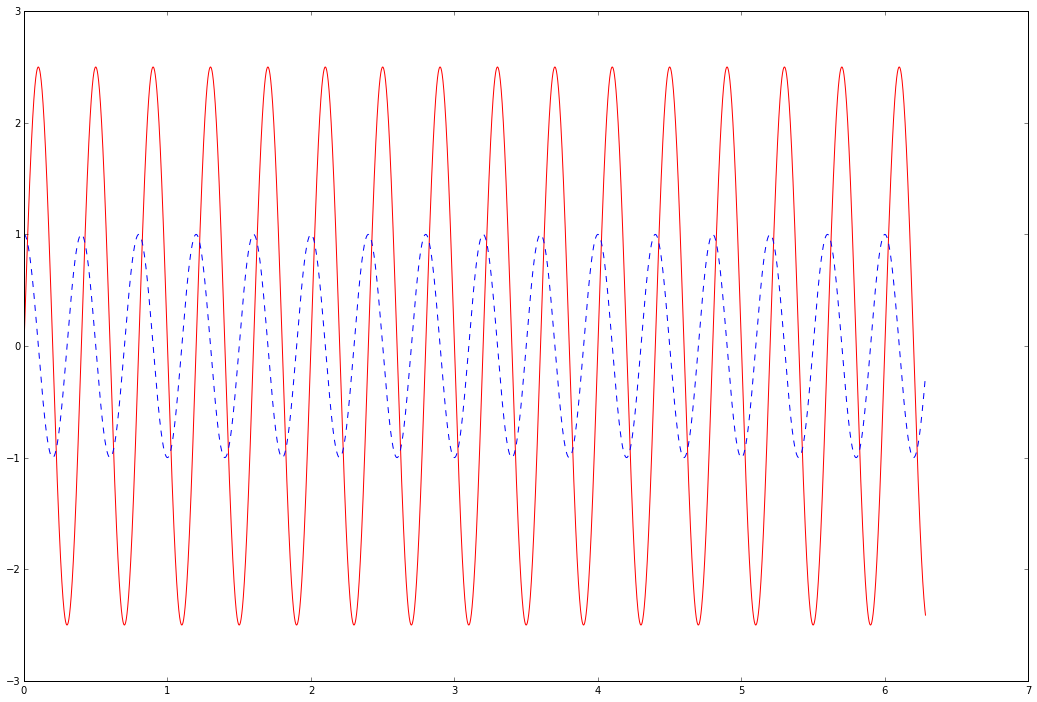

None

<function __main__.plot_sin_cos>

In [23]:
from IPython.display import clear_output

x = np.arange(0, 2*np.pi, 0.001)

def plot_sin_cos(amplitude, period):
    plt.plot(x, amplitude * np.sin(2*np.pi*x*period), 'r-')
    plt.plot(x, np.cos(2*np.pi*x*period), 'b--')
    clear_output(wait=True)
    display(plt.show())
    
interact(plot_sin_cos, amplitude=(0.1, 5.0, 0.1), period=(0.1, 5.0, 0.1))

In [24]:
# Example 2
from ipywidgets import widgets 

print ('This element contains uppercased text from the bottom text element.')
# Display the text widget
outputText = widgets.Text()  
outputText

This element contains uppercased text from the bottom text element.


In [25]:
def uppercase(sender):
    outputText.value = inputText.value.upper()
    
print ('Type some text here and it will appear in upper text element and "Enter" clicking.')
# Display the text widget
inputText = widgets.Text()
# Add event listener which activates at "Enter" clicking
inputText.on_submit(uppercase)
inputText

Type some text here and it will appear in upper text element and "Enter" clicking.


In [26]:
# Example 3
def on_button_clicked(event):
    # transform a text to its palindrome
    text.value = text.value[::-1]
    
# Display the text widget
text = widgets.Text(description="Type some text here:", width=200)  
display(text)

#add button that updates the graph based on the checkboxes
button = widgets.Button(description="Transform input text")
display(button)

# Add event listener which activates at click on button
button.on_click(on_button_clicked)  

In [ ]:
# And now we may implement our plan about updated map
def get_routes_for_airport(sender):
    # Draw the map
    themap = Basemap(projection='robin', resolution = 'c', area_thresh = 10000.0, lat_0=-90, lon_0=10)
    themap.fillcontinents(color='lightgray', lake_color='lightblue')
    themap.drawmapboundary(fill_color='lightblue')
    themap.drawcountries()
    themap.drawcoastlines()

    text = inputAirportIdentificator.value.lower()
    # Check if ID was typed
    try:
        text = int(text)
    except ValueError:
        pass
    
    # Find the airport by ID or `name`
    if isinstance(text, int):
        source = airports[airports["IATA_CODE"] == text].iloc[0]
        condition = lambda row: row["ORIGIN_AIRPORT"] == text
    else:
        source = airports[airports["IATA_CODE"].apply(lambda x: x.lower()) == text].iloc[0]
        text = source['IATA_CODE']
    
    # If there are more then one the same source and destination airports
    # we won't draw this trajectory again
    exist = []
    
    # Find all destination airports where source airport is `source`
    for name, row in flights.iterrows():
        if row["ORIGIN_AIRPORT"] == text and row['DESTINATION_AIRPORT'] not in exist:
            try:
                # Get the destination airport
                dest = airports[airports["IATA_CODE"] == row["DESTINATION_AIRPORT"]].iloc[0]
                # Draw a great circle between source and dest airports.
                themap.drawgreatcircle(source["LONGITUDE"], source["LATITUDE"], 
                                       dest["LONGITUDE"], dest["LATITUDE"],
                                       linewidth=1, color='b'
                                      )
                exist.append(row['DESTINATION_AIRPORT'])
            except (ValueError, IndexError):
                pass
    
    # Delete the previous map if it is build
    clear_output(wait=True)
    display(plt.show())

inputAirportIdentificator = widgets.Text(description="Type airport IATA CODE:", width=400) 
display(inputAirportIdentificator)
inputAirportIdentificator.on_submit(get_routes_for_airport)

Often very informative geovisualization can be reached with the help of globes. `basemap` also provides the possibility of the globe using. Let's build an interactive rotating globe where we random 100 airports with the help of markers. 

In [ ]:
import numpy as np

# Random choice of 100 rows from `airports` DataFrame 
array = []
for i, row in airports.sample(100).iterrows():
    array.append((row['LONGITUDE'], row['LATITUDE']))
    
# Change the size of the image for globe
plt.rcParams['figure.figsize'] = (8, 8)

def globe(lon, lat):
    themap = Basemap(projection='ortho', lon_0=lon, lat_0=lat, resolution='c', area_thresh=10000.0)
    
    themap.drawcoastlines()
    themap.fillcontinents(color='lightseagreen', lake_color='lightskyblue')
    themap.drawparallels(np.arange(-80.,81.,20.))
    themap.drawmeridians(np.arange(-180.,180.,20.))
    themap.drawmapboundary(fill_color='lightblue')
    themap.drawcountries()
    
    # Add markers
    for i in array:
        x, y = themap(i[0], i[1])
        themap.plot(x, y, 'o', color="mediumpurple", markersize=8)
    
    plt.title("Rotatable globe")
    clear_output(wait=True)
    display(plt.show())
    
interact(globe, lon=(-360,180,1), lat=(-45,90,1))

> ### Exercise 1.3: 

> `flights` DataFrame contains distance in miles and cootdinates of source and destination airports. Let's caclulate distetnce in kilometres as distetnce between origin and destination airports and draw 10 the longest trajectories between two airports on the map using `basemap`. And the end you can compare actual and calculated distances. Set the following parameters for the map

> <span style="margin-left: 30px"></span>`map = Basemap(projection='hammer', resolution='c', area_thresh=10000.0, lon_0=-90)`<br></br>
> <span style="margin-left: 30px"></span>`map.fillcontinents(color='coral', lake_color='aqua')`<br></br>
> <span style="margin-left: 30px"></span>`map.drawmapboundary(fill_color='aqua')`<br></br>
> <span style="margin-left: 30px"></span>`map.drawcountries()`<br></br>
> <span style="margin-left: 30px"></span>`map.drawcoastlines()`

> and the following attributes for `drawgreatcircle()` function: `linewidth=2, color='g'`.

> In order to do this, you need to first calculate route lengths. Let's use [haversine distance](https://en.wikipedia.org/wiki/Haversine_formula), that calculates the distance between latitude, longitude pairs (in our case, between latitude and longitude values of source and destination airports):
$$d = 2 r \arcsin\left(\sqrt{\sin^2\left(\frac{\varphi_2 - \varphi_1}{2}\right) + \cos(\varphi_1) \cos(\varphi_2)\sin^2\left(\frac{\lambda_2 - \lambda_1}{2}\right)}\right),$$
$\varphi_1$ and $\varphi_2$: latitude of point 1 and latitude of point 2; <br></br>
$\lambda_1$ and $\lambda_2$: longitude of point 1 and longitude of point 2; <br></br>
let's consider the average Earth radius $r$ is equal to 6367 km and neglect by flying height and airport altitude.  

> Write to the `top10_lines` Python list data about the found 10 lines connecting some two airports. The `top10_lines` list should contain data about source and destination airports, all airlines flying between these airports and the length (below `line_length`) of the trajectory in kilometers (round this value to three numbers after coma). 

> Each element of `top10_lines` should have the following form 

> <span style="margin-left: 30px"></span>`((ORIGIN_AIRPORT, DESTINATION_AIRPORT), [AIRLINE_1, AIRLINE_2, ...], line_length)`

> where

> * `(ORIGIN_AIRPORT, DESTINATION_AIRPORT)` is the tuple containg ids of source and destination airports ordered by alpahabet (i.e. if you have `"ORIGIN_AIRPORT" = JFK` and `"DESTINATION_AIRPORT" = HNL`, then you should write them as `(HNL, JFK)`)

> * `[AIRLINE_1, AIRLINE_2, ...]` is the list with ids of all unique airlines working on this route ordered by `"AIRLINE"`

> For example, 

> <span style="margin-left: 30px"></span>`top10_lines = [..., (('EWR', 'HNL'), ['UA'], 7968.369), ..., (('ATL', 'HNL'), ['DL'], 7229.354), ...]`

> Sort the `top10_lines` in descending order by `line_length` value.

> Visualize also airports from the `top10_lines` list using markers with attributes `marker='o', color='b', markersize=10`.

> This calculation can take a long time. 

> Your map should have the view like 

> <img src="images/ex32_3.png">

> Save the map as "lab3_2_ex_3.png".

In [ ]:
# type your code here

# top10_lines = ...

#plt.savefig("lab3_2_ex_3.png")
#plt.show()

In [ ]:
Test.assertEqualsHashed(top10_lines, 'be4549ed01cdb7ea599a1c90d8ea26a4de3ea448', 
                        'Incorrect content of "top10_lines"', "Exercise 1.3.1 is successful")
Test.assertEqualsImagesHashed("lab3_2_ex_3.png", '410e2f2b1b0f0c41', 'RGBA', (1296, 864),
                              'Incorrect plot image', "Exercise 1.3.2 is successful")

<center><h3>Presented by <a target="_blank" rel="noopener noreferrer nofollow" href="http://datascience-school.com">datascience-school.com</a></h3></center>